<a href="https://colab.research.google.com/github/anton-akulenko/HW02-DS/blob/main/DS_HW_8(NN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras as K

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.0007 #0.001 швидкість навчання нейронної мережі
training_steps = 2000 #3000 максимальне число епох
batch_size = 256 #256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.out_layer(x, activation=1)

    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати етикетку в один гарячий вектор.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення кліпу, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівнюємо передбачені значення з істинними мітками
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Обчислюємо середню точність з використанням згортання
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        loss_history.append(loss)
        acc = accuracy(pred, batch_y)
        accuracy_history.append(acc)
        print(f"Step {round(step / 100)+1}, Loss: {loss}, Accuracy: {acc}")


Step 1, Loss: 1849.4539794921875, Accuracy: 0.140625
Step 2, Loss: 348.60369873046875, Accuracy: 0.64453125
Step 3, Loss: 282.8472595214844, Accuracy: 0.68359375
Step 4, Loss: 248.9014129638672, Accuracy: 0.765625
Step 5, Loss: 188.3390655517578, Accuracy: 0.7890625
Step 6, Loss: 187.01263427734375, Accuracy: 0.82421875
Step 7, Loss: 187.76580810546875, Accuracy: 0.796875
Step 8, Loss: 110.37619018554688, Accuracy: 0.875
Step 9, Loss: 130.47402954101562, Accuracy: 0.859375
Step 10, Loss: 142.02886962890625, Accuracy: 0.8515625
Step 11, Loss: 114.31837463378906, Accuracy: 0.88671875
Step 12, Loss: 145.85220336914062, Accuracy: 0.84765625
Step 13, Loss: 110.16889953613281, Accuracy: 0.87109375
Step 14, Loss: 132.27505493164062, Accuracy: 0.83984375
Step 15, Loss: 73.67814636230469, Accuracy: 0.91015625
Step 16, Loss: 126.36478424072266, Accuracy: 0.875
Step 17, Loss: 77.43090057373047, Accuracy: 0.90625
Step 18, Loss: 97.62405395507812, Accuracy: 0.88671875
Step 19, Loss: 96.839752197265

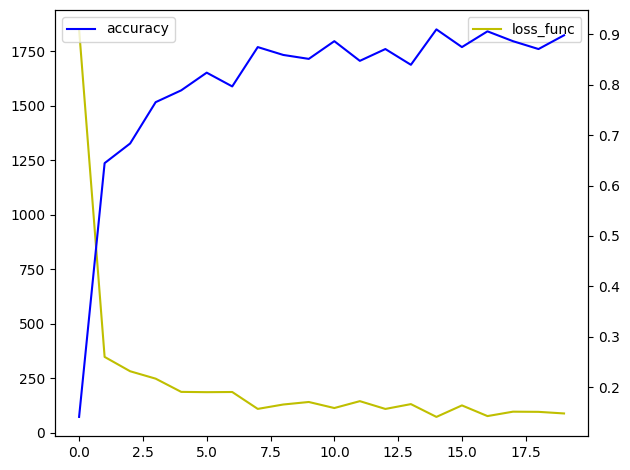

In [8]:
# Виведи графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

fig, axs = plt.subplots()
axs.plot(loss_history, 'y', label='loss_func')
axs.legend()

axs2=axs.twinx()
axs2.plot(accuracy_history, 'b', label='accuracy')
plt.legend()


plt.tight_layout()
plt.show()


In [9]:
neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"NN accuracy: {neural_net_accuracy*100:.2f}%")
test_pred = neural_net(x_test)
print(f"Test data accuracy: {accuracy(test_pred, y_test)*100:.2f}%")

NN accuracy: 89.07%
Test data accuracy: 87.46%


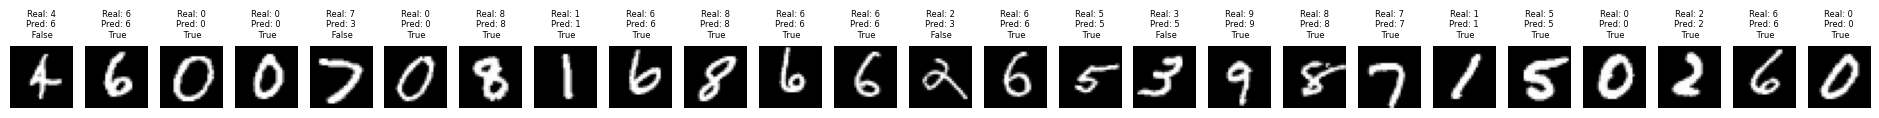

Accuracy of 25 digits above is 84.00%
Mistakes: 
Real: [4, 7, 2, 3] 
Pred: [6, 3, 3, 5]


In [15]:
# Протестуємо навчену нейромережу на 10 зображеннях. З тестової вибірки візьми 5
# випадкових зображень і передай їх у нейронну мережу.
# Виведи зображення та випиши поруч відповідь нейромережі.
# Зроби висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random
test_examples =25
random_indices = random.sample(range(len(x_test)), test_examples)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

# Прогнозуємо класи для вибраних зображень
predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виведемо зображення та випишемо поруч відповідь нейромережі
plt.figure(figsize=(24, 6))
d, pr = [], []
for i in range(test_examples):
    plt.subplot(1, test_examples, i + 1)
    plt.imshow(test_images[i].reshape((28, 28)), cmap='gray')
    if test_labels[i] - predicted_labels[i] != 0:
      d.append(test_labels[i]), pr.append(predicted_labels[i])
    plt.title(f"Real: {test_labels[i]}\nPred: {predicted_labels[i]}\n {False if test_labels[i] - predicted_labels[i] != 0 else True}", fontsize = 6)
    plt.axis('off')

plt.show()

# Порівняємо прогнози з правильними мітками та обчислимо точність
correct_predictions = (predicted_labels == test_labels)
accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Accuracy of {test_examples} digits above is {accuracy * 100:.2f}%")
print(f"Mistakes: \nReal: \033[92m{d}\033[0m \nPred: \033[91m{pr}\033[0m")
